# Activity 5

## Segmentation

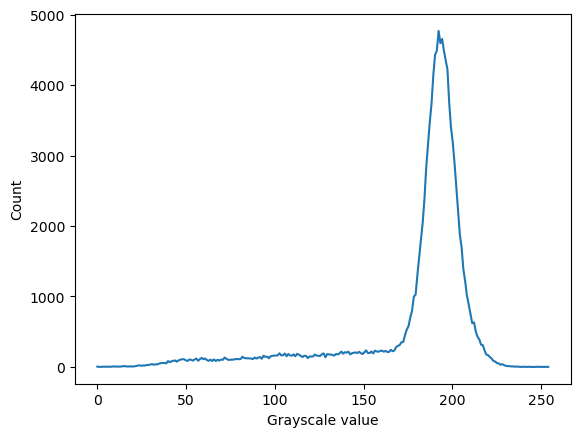

In [2]:
import numpy as np
import matplotlib.pyplot as plt

check = plt.imread('cropped_grayscale_check.jpg')

count, cells = np.histogram(check.flatten(),256)
plt.plot(cells[:-1],count)
plt.xlabel('Grayscale value')
plt.ylabel('Count')
plt.show()

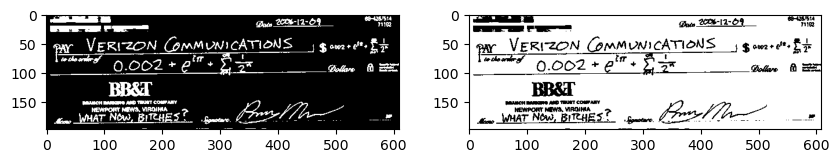

In [3]:
ROI_less = check < 150
ROI_greater = check > 150

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plt.imshow(ROI_less, cmap='gray')
ax = fig.add_subplot(122)
plt.imshow(ROI_greater, cmap='gray')

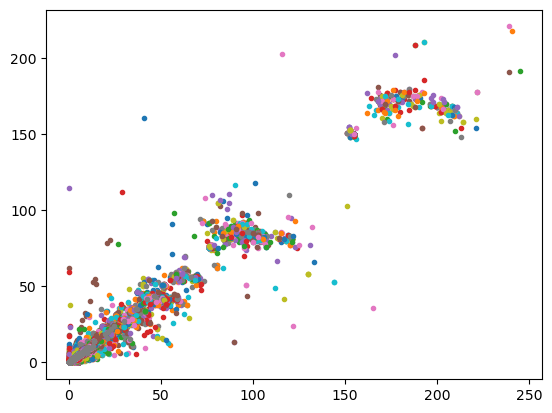

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


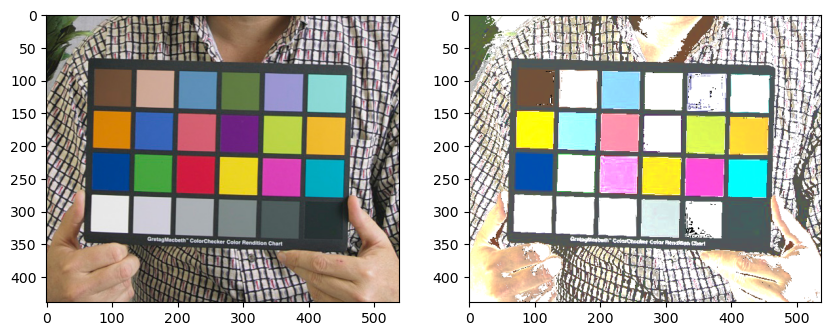

In [5]:
def img_norm(img):
#     img = img/255
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    I = R+G+B
    I = np.where(I==0, 10e10, I)
    R_norm = R/I
    G_norm = G/I
    B_norm = B/I
    img_norm = np.dstack([R_norm,G_norm,B_norm])
    return img_norm

color_checker = plt.imread('Gretag-Macbeth_ColorChecker.jpg')
color_checker_norm = img_norm(color_checker)

color_checker_norm
plt.plot(color_checker_norm[:,:,0],color_checker_norm[:,:,1], '.')
plt.show()
color_checker_norm
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(121)
plt.imshow(color_checker)
ax = fig.add_subplot(122)
plt.imshow(color_checker_norm)
# plt.colorbar()
# print(color_checker[0,2,0], color_checker[0,2,1], color_checker[0,2,2], color_checker_norm[0,2,0])